In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import AutoModel, AutoTokenizer
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

from timm.data import resolve_data_config, create_transform

import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset

In [ ]:
from timm import create_model

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device("cuda")
    print("GPU Device Name:", torch.cuda.get_device_name(0))  # Assuming you have one GPU
else:
    print("GPU is not available.")
    device = torch.device("cpu")

GPU is available.
GPU Device Name: Tesla T4


In [ ]:
# Read the CSV file
df = pd.read_csv("/content/drive/MyDrive/Image Dataset Curation/Image_Dataset_Final.csv")

# Drop rows with missing values
#df = df.dropna(subset=['image_path', 'Avg Global CMP22 (vent/cor) [W/m^2]'])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataframe.iloc[idx]['image_path'])
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        target = torch.tensor(float(self.dataframe.iloc[idx]['Avg Global CMP22 (vent/cor) [W/m^2]']))
        return img, target


In [ ]:
import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import timm
model = timm.create_model('inception_v4', pretrained=True)
#model.eval()

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
# Assuming you have a 'datetime' column in your DataFrame
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime')

# Define the percentage of data for training, validation, and testing
train_percentage = 0.6
val_percentage = 0.2
test_percentage = 0.2

# Calculate the split indices
train_index = int(train_percentage * len(df))
val_index = int((train_percentage + val_percentage) * len(df))

# Split the data
train_df = df[:train_index]
val_df = df[train_index:val_index]
test_df = df[val_index:]

# Create custom datasets and data loaders
batch_size = 32

train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Change the final layer for regression
# Modify the last layer for regression
num_features = model.last_linear.in_features
model.last_linear = nn.Linear(num_features, 1)  # 1 output for regression

In [ ]:
# Set the model to evaluation mode
model.eval()

# Enable GPU if available
model = model.to(device)

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Early stopping parameters
early_stop_threshold = 3  # Number of epochs without improvement to trigger early stopping
best_val_loss = float('inf')
counter_no_improvement = 0

In [ ]:
# Train the model
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), targets.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Learning rate scheduler step
    #scheduler.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            val_loss += criterion(outputs.squeeze(), targets.float())

    val_loss /= len(val_loader)
    train_loss /= len(train_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

     # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter_no_improvement = 0
    else:
        counter_no_improvement += 1

    if counter_no_improvement >= early_stop_threshold:
        print(f"Early stopping at epoch {epoch+1}")
        break

In [ ]:
# Check gradients after training
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.grad}")

val_losses_cpu = [loss.cpu().detach().numpy() for loss in val_losses]

In [ ]:
train_losses

[195651.83432904413,
 186049.4005055147,
 176250.90435431985,
 166335.01953125,
 156537.15205652572,
 145460.32938878678,
 133827.6729485007,
 122290.1571116728,
 110731.77711397059,
 98717.79621438419,
 87733.22802734375,
 77941.59242876839,
 69632.90059168199,
 60501.230985753675,
 53337.787296070775,
 45769.54228659237,
 38956.568258846506,
 33400.74766989315,
 28127.60596780216,
 24335.240873448987,
 20142.13151101505,
 17215.132475909064,
 14768.758721744312,
 13132.55384647145,
 10117.34939664953,
 9069.219109927906,
 7265.336091883042,
 6780.096518123851,
 6222.926613302792]

In [ ]:
val_losses_cpu

[array(225738.14, dtype=float32),
 array(214337.5, dtype=float32),
 array(201971.1, dtype=float32),
 array(190726.95, dtype=float32),
 array(173645.53, dtype=float32),
 array(159051.44, dtype=float32),
 array(136913.53, dtype=float32),
 array(129490.055, dtype=float32),
 array(126984.18, dtype=float32),
 array(102921.21, dtype=float32),
 array(106302.93, dtype=float32),
 array(82433.695, dtype=float32),
 array(83931.75, dtype=float32),
 array(74403.13, dtype=float32),
 array(63225.848, dtype=float32),
 array(51107.98, dtype=float32),
 array(46069.273, dtype=float32),
 array(48101.543, dtype=float32),
 array(34076.984, dtype=float32),
 array(25171.299, dtype=float32),
 array(24734.709, dtype=float32),
 array(31616.922, dtype=float32),
 array(24048.234, dtype=float32),
 array(28058.771, dtype=float32),
 array(23819.805, dtype=float32),
 array(19353.807, dtype=float32),
 array(23597.465, dtype=float32),
 array(23483.248, dtype=float32),
 array(20407.318, dtype=float32)]

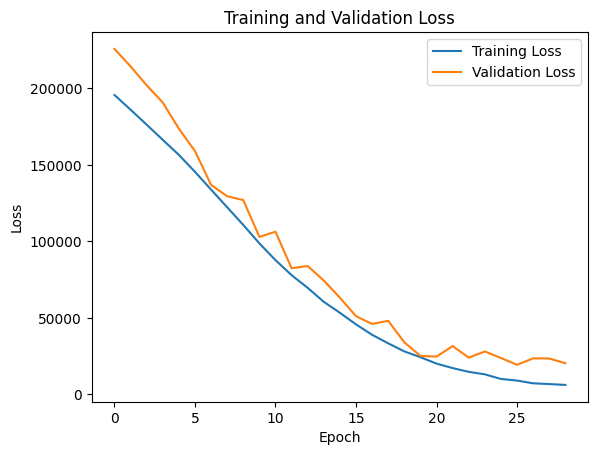

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses_cpu)), val_losses_cpu, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the plot to Google Drive
save_path = '/content/drive/MyDrive/Forecasting Models/Inception_V4/training_loss_curve.png'
plt.savefig(save_path)

plt.show()

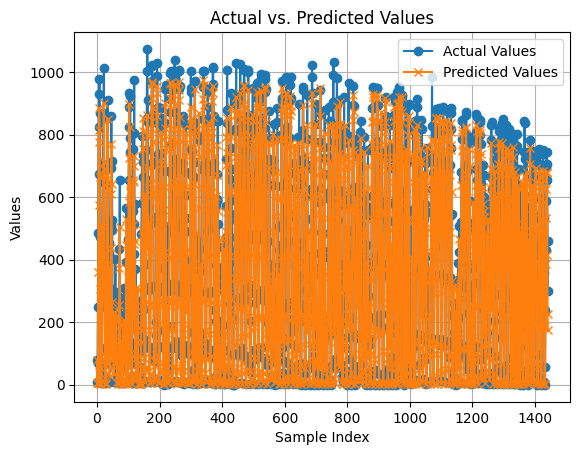

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


model.eval()
predictions = []
actual_values = []

with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        predictions.extend(outputs.cpu().numpy())
        actual_values.extend(targets.cpu().numpy())

# Convert the lists to NumPy arrays
predictions = np.array(predictions)
actual_values = np.array(actual_values)

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' and 'actual_values' are NumPy arrays
# Make sure they have the same shape and represent the same samples

# Create an array of indices (e.g., for x-axis)
indices = np.arange(len(predictions))

# Line plot of actual values and predicted values
plt.plot(indices, actual_values, label='Actual Values', marker='o')
plt.plot(indices, predictions, label='Predicted Values', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)


# Save the plot to Google Drive
save_path = '/content/drive/MyDrive/Forecasting Models/Inception_V4/actual_vs_predicted.png'
plt.savefig(save_path)


plt.show()

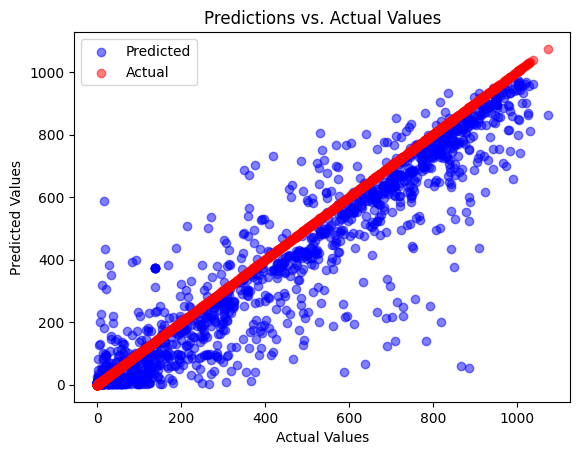

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have actual_values and predictions as NumPy arrays or lists
# You can replace these with your actual data

# Scatter plot with different colors
plt.scatter(actual_values, predictions, c='blue', label='Predicted', alpha=0.5)
plt.scatter(actual_values, actual_values, c='red', label='Actual', alpha=0.5)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs. Actual Values')

# Add a legend to distinguish between actual and predicted values
plt.legend()

# Save the plot to Google Drive
save_path = '/content/drive/MyDrive/Forecasting Models/Inception_V4/scatter_plot_ActualVsPredicted.png'
plt.savefig(save_path)

plt.show()

In [ ]:
# Save the entire model (including architecture, parameters, and optimizer state)
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, '/content/drive/MyDrive/Forecasting Models/Inception_V4/model_final_december_checkpoint.pth')

In [ ]:
#R2
from sklearn.metrics import r2_score

score = r2_score(actual_values, predictions)

print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.851.


In [ ]:
from sklearn.metrics import mean_absolute_error as mae
k = mae(predictions, actual_values)
print('Test Mean Absolute Error    ', k )

Test Mean Absolute Error     83.43896


In [ ]:
from sklearn import metrics

In [ ]:
# RMSE
print(np.sqrt(metrics.mean_squared_error(predictions, actual_values)))

125.16586


In [ ]:
predicted1=list(predictions)
actual1=list(actual_values)

In [ ]:
predicted1[:5]

[array([78.55331], dtype=float32),
 array([5.4298377], dtype=float32),
 array([6.4009385], dtype=float32),
 array([4.528181], dtype=float32),
 array([360.33023], dtype=float32)]

In [ ]:
actual1[:5]

[79.2729, 7.6517, 69.0001, 249.4131, 485.2302]